

Denoising a corrupted image using Bayesian inference with a very simple prior.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This next routine loads in an image. We will be working with `noisy_bear.png`, which is a corrupted version of `original_bear.png`. The image is 62-by-62; we binarize it (to values -1 and +1) and then embed it in the center of a 64-by-64 image whose edges are padded with zeros.

In [ ]:
# Subroutine for loading an image
# Any pixel with value >= 128 is set to +1
# Any pixel with value < 128 is set to -1
def load_image(filename):
  img = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
  img = img/255.0
  img[img>=0.5]=1.0
  img[img<0.5]=0.0
  img = img*2-1
  return img

# Load in both the degraded image and the original
img = load_image("/content/drive/My Drive/DSC 257R/gibbs/noisy_bear.png")
gt = load_image("/content/drive/My Drive/DSC 257R/gibbs/original_bear.png")
M,N = img.shape[0], img.shape[1]

# Create a version of img that is padded with zeros all around
padded_image = np.zeros((img.shape[0]+2, img.shape[1]+2)) #Padding image to make some computations easier
padded_image[1:-1,1:-1] = img

### <font color='blue'>The probabilistic model</font>

Let $X$ denote the degraded image (of size $M \times N$) and $Y$ the original that we wish to reconstruct (warning: we used the opposite notation in lecture). We will posit a simple probabilistic model of the joint distribution of $(X,Y)$:


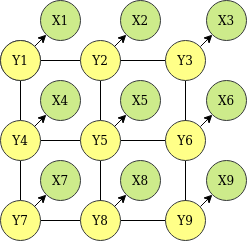


Let $p = (i,j)$ denote a position in the image and let $X_p = X(i,j), Y_p = Y(i,j)$ be the values of $X$ and $Y$ at that location. Recall that these values are -1 or +1. Write $p \sim q$ if $p,q$ are neighboring pixels; note that pixel $p = (i,j)$ has neighbors ${\mathcal{N}}(p) = \{ (i-1,j), (i+1,j), (i,j-1), (i,j+1)\}$. Then the probability of $X,Y$ is:

$$Pr(X,Y) \propto \prod\limits_{p \in [M] \times [N]} \phi(X_{p},Y_{p})\prod\limits_{p \sim q}\phi(Y_p, Y_q) $$

Notice that here all clique potentials are identical functions. We will use $\phi(u, v) = e^{uv}$.

### <font color='blue'>Sampling from the posterior</font>

We wish to sample from the <b>posterior distribution over $Y$ given $X$</b>. We'll do this using Gibbs sampling:

* We will initialize the recovered image with each pixel set uniformly to $\{-1,+1\}$
* We will then repeatedly choose a pixel $p$ to update and re-sample its value from $Pr(Y_p | X, Y_{\setminus p})$.



In [ ]:
def calculate_probability(Y, X, beta, i, j):
    """
    Calculates Pr(Y_p = +1 | Y_{\backslash p}, X) for a pixel (i, j).
    """
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    neighbor_sum = sum(Y[x, y] for x, y in neighbors if 0 <= x < Y.shape[0] and 0 <= y < Y.shape[1])
    # Calculate the probability ratio
    exp_positive = np.exp(beta * (neighbor_sum + X[i, j]))
    exp_negative = np.exp(-beta * (neighbor_sum + X[i, j]))
    probability_positive = exp_positive / (exp_positive + exp_negative)
    return probability_positive

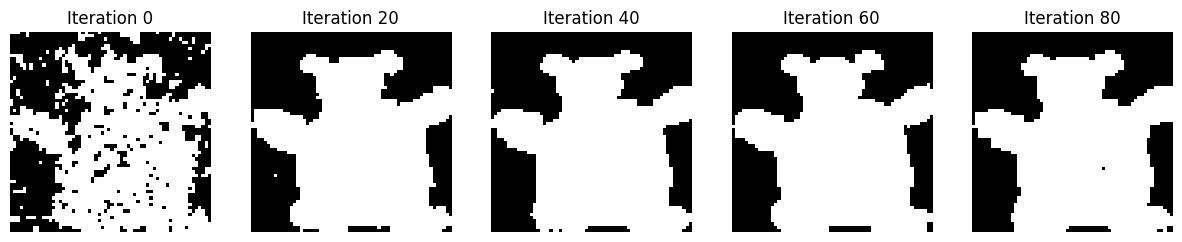

In [ ]:
# Initialize Y randomly with -1 or +1
Y = np.random.choice([-1, 1], size=img.shape)

# Parameters for Gibbs sampling
beta = 1.0
iterations = 100  # Number of Gibbs sampling iterations
snapshots = []

# Run Gibbs sampling
for iteration in range(iterations):
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            prob = calculate_probability(Y, img, beta, i, j)
            Y[i, j] = 1 if np.random.rand() < prob else -1
    # Save intermediate images at regular intervals
    if iteration % (iterations // 5) == 0:  # 5 snapshots for visualization
        snapshots.append(Y.copy())

# Display snapshots
fig, axs = plt.subplots(1, len(snapshots), figsize=(15, 3))
for idx, snap in enumerate(snapshots):
    axs[idx].imshow(snap, cmap='gray')
    axs[idx].set_title(f'Iteration {idx * (iterations // 5)}')
    axs[idx].axis('off')
plt.show()

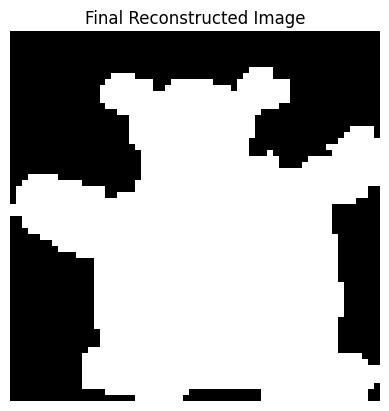

In [ ]:
# Final reconstructed image using the expectation of Y given X
final_image = np.sign(Y)

# Display the final reconstructed image
plt.imshow(final_image, cmap='gray')
plt.title("Final Reconstructed Image")
plt.axis('off')
plt.show()